## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


### __1.
Похожи логикой нахождения похожих пользователей для user-user и товаров для item-item (косинусное сходство, ...)

Отличия в применимости, item-item больее применим из-за условной стабильности количества и характеристик товаров, а user-user количество пользователей больше чем товаров в несколько порядков (постоянное увеличение...)-> сложность выше чем item-item в пропорциях количества.



Нельзя использовать функции одного алгоритма в другом 

item-item учитывает схожесть товаров, а ALS учитывает как и латентные факторы пользователей, и латентные факторы товаров.


2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


### __2.

Отзывы на товары или иной продукт после покупки,
наличие дополнения к отзыву по прошествию времени(+ -> +, - -> +, + -> -, + -> +).

Покупка при наличии скидок и при отсутствии,
повторные покупки товаров на которые закончились скидки
(то есть 1: купили со скидкой 2: купили без скидки)
по логике это будет показывать приверженость этому товару(в некоторых случаях)

средняя скидка на товары у пользователя


3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)

### __3.

Тип информации - числовой,
не может работать с внешними данными,
только позитивные взаиможействия


4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

## Практическая часть


In [1]:
import implicit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.metrics import precision_at_k 

In [3]:
data = pd.read_csv('../data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
item_features = pd.read_csv('../data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
valid_result = data_test.groupby('user_id')['item_id'].unique().reset_index()
valid_result.columns=['user_id', 'actual']
valid_result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [6]:
train_result = data_train.groupby('user_id')['item_id'].unique().reset_index()
train_result.columns=['user_id', 'actual']
train_result.head(2)

,user_id,actual
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."


### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов).

Обучите алгоритм для различных $C$.

В качестве результата приведите таблицу:

    матрица весов - результат на train и validation.

Сделате качественные выводы.


In [7]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [8]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # стоимость покупки
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/home/oleg_rev/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [10]:
csr_mat = csr_matrix(user_item_matrix).T.tocsr()

In [11]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)


CPU times: user 14 s, sys: 43.8 ms, total: 14.1 s
Wall time: 3.82 s


In [12]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [13]:
%%time
    
train_result['als'] = train_result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
train_result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 23 s, sys: 9.15 ms, total: 23 s
Wall time: 22.7 s


0.5926370548219242

In [14]:
%%time
    
valid_result['als'] = valid_result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
valid_result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 20.5 s, sys: 4.43 ms, total: 20.5 s
Wall time: 20.5 s


0.10146914789422061

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [15]:
lambda_regs = [0.01/(10**i) for i in range(4)]
lambda_regs

[0.01, 0.001, 0.0001, 1e-05]

In [16]:
n_factors =  [round(200/(2**i)) for i in range(5)]
n_factors

[200, 100, 50, 25, 12]

In [17]:
from time import time

In [18]:
hyperparam_result={
    'lambda_regularizations':[],
    'n_factors':[],
    'fit_time':[],
    'train_precision':[],
    'valid_precision':[]
}


first_time = time()
i=0
for lambda_reg in lambda_regs:
    for n_factor in n_factors:
        hyperparam_result['lambda_regularizations'].append(lambda_reg)
        hyperparam_result['n_factors'].append(n_factor)

        start_time = time()
        
        model = AlternatingLeastSquares(factors=n_factor, #k
                                regularization=lambda_reg,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)        
        model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=False)
        
        end_time = time()
        
        hyperparam_result['fit_time'].append(end_time-start_time)
        res_name = f'ALS: lambda_regularizations {lambda_reg}, n_factors: {n_factor}'
        
        train_result[res_name] = train_result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        train_precision = train_result.apply(lambda row: precision_at_k(row[res_name], row['actual']), axis=1).mean()
                
        hyperparam_result['train_precision'].append(train_precision)

        valid_result[res_name] = valid_result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        valid_precision = valid_result.apply(lambda row: precision_at_k(row[res_name], row['actual']), axis=1).mean()
        
        hyperparam_result['valid_precision'].append(valid_precision)
        
        cycle_time = time()
        i+=1
        print(f'Цикл {i} из 20, времени прошло {(cycle_time-first_time):.2f}')



Цикл 1 из 20, времени прошло 108.04
Цикл 2 из 20, времени прошло 155.95
Цикл 3 из 20, времени прошло 193.01
Цикл 4 из 20, времени прошло 223.28
Цикл 5 из 20, времени прошло 248.06
Цикл 6 из 20, времени прошло 356.63
Цикл 7 из 20, времени прошло 405.49
Цикл 8 из 20, времени прошло 436.91
Цикл 9 из 20, времени прошло 467.75
Цикл 10 из 20, времени прошло 495.44
Цикл 11 из 20, времени прошло 599.32
Цикл 12 из 20, времени прошло 645.21
Цикл 13 из 20, времени прошло 676.76
Цикл 14 из 20, времени прошло 704.40
Цикл 15 из 20, времени прошло 728.69
Цикл 16 из 20, времени прошло 834.90
Цикл 17 из 20, времени прошло 884.25
Цикл 18 из 20, времени прошло 919.53
Цикл 19 из 20, времени прошло 950.55
Цикл 20 из 20, времени прошло 975.04


In [21]:
hyperparam_result_ = hyperparam_result
hyperparam_result

,lambda_regularizations,n_factors,fit_time,train_precision,valid_precision
0,0.01000,200,6.059940,0.754702,0.108423
1,0.01000,100,3.402284,0.595198,0.103330
2,0.01000,50,3.523757,0.517407,0.105485
3,0.01000,25,3.444627,0.484914,0.109892
4,0.01000,12,2.182488,0.465866,0.128012
5,0.00100,200,6.066531,0.766467,0.108031
6,0.00100,100,3.209432,0.593277,0.099706
7,0.00100,50,3.362695,0.508443,0.100196
8,0.00100,25,2.803600,0.472509,0.107835
9,0.00100,12,2.121684,0.462985,0.121058


In [22]:
hyperparam_result = pd.DataFrame(hyperparam_result)
hyperparam_result


,lambda_regularizations,n_factors,fit_time,train_precision,valid_precision
0,0.01000,200,6.059940,0.754702,0.108423
1,0.01000,100,3.402284,0.595198,0.103330
2,0.01000,50,3.523757,0.517407,0.105485
3,0.01000,25,3.444627,0.484914,0.109892
4,0.01000,12,2.182488,0.465866,0.128012
5,0.00100,200,6.066531,0.766467,0.108031
6,0.00100,100,3.209432,0.593277,0.099706
7,0.00100,50,3.362695,0.508443,0.100196
8,0.00100,25,2.803600,0.472509,0.107835
9,0.00100,12,2.121684,0.462985,0.121058


In [23]:
hyperparam_result.loc[hyperparam_result['n_factors']==12]

,lambda_regularizations,n_factors,fit_time,train_precision,valid_precision
4,0.01000,12,2.182488,0.465866,0.128012
9,0.00100,12,2.121684,0.462985,0.121058
14,0.00010,12,2.173090,0.459624,0.121156
19,0.00001,12,2.111594,0.458503,0.120078


In [32]:
hyperparam_result.loc[hyperparam_result['lambda_regularizations']==0.01]

,lambda_regularizations,n_factors,fit_time,train_precision,valid_precision
0,0.01,200,6.059940,0.754702,0.108423
1,0.01,100,3.402284,0.595198,0.103330
2,0.01,50,3.523757,0.517407,0.105485
3,0.01,25,3.444627,0.484914,0.109892
4,0.01,12,2.182488,0.465866,0.128012


In [29]:
hyperparam_result_0_ = hyperparam_result_0
hyperparam_result_0 = pd.DataFrame(hyperparam_result_0)

In [31]:
hyperparam_result_0

,lambda_regularizations,n_factors,fit_time,train_precision,valid_precision
0,1.000,12,2.673662,0.468828,0.126543
1,1.000,6,2.690371,0.474350,0.144172
2,1.000,3,2.091671,0.481473,0.160333
3,1.000,2,2.079388,0.483153,0.171694
4,1.000,1,1.311913,0.480112,0.179628
5,0.100,12,1.800918,0.468667,0.128404
6,0.100,6,2.214629,0.475630,0.145446
7,0.100,3,2.083740,0.481633,0.161312
8,0.100,2,2.114206,0.484034,0.171499
9,0.100,1,1.305642,0.480112,0.179628


In [46]:
def show_precision_on_hyper_params(hyperparam_result, precision_on_data = 'train_precision'):
    n_factors = hyperparam_result['n_factors'].unique()
    lambda_regularizations = hyperparam_result['lambda_regularizations'].unique() 
    for n_factor in n_factors:
        plt.plot(lambda_regs,hyperparam_result.loc[hyperparam_result['n_factors']==n_factor,f'{precision_on_data}'], label = f'n_factor = {n_factor}')
    plt.legend()
    plt.xlabel('lambda_regularizations')
    plt.ylabel('precision@k')
    plt.title(f'Качество({precision_on_data}) от гиперпараметра lambda_regularizations')
    plt.show()
    
    for lambda_reg in lambda_regularizations:
        plt.plot(n_factors,hyperparam_result.loc[hyperparam_result['lambda_regularizations']==lambda_reg,f'{precision_on_data}'], label = f'lambda_reg = {lambda_reg}')
    plt.legend()
    plt.xlabel('n_factors')
    plt.ylabel('precision@k')
    plt.title(f'Качество({precision_on_data}) от гиперпараметра n_factors')
    plt.show()
    
    

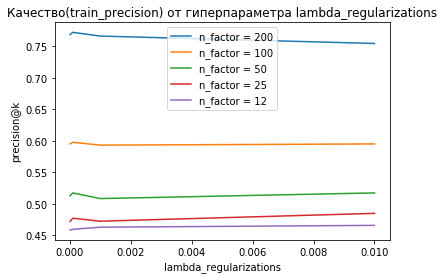

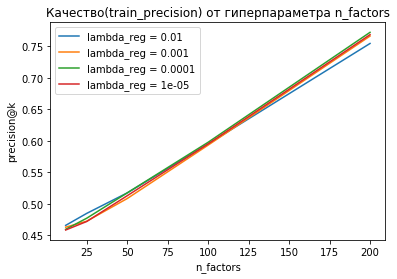

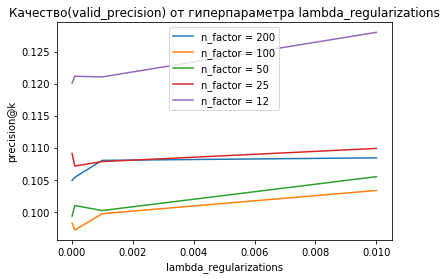

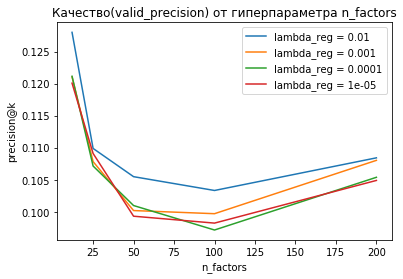

In [50]:
show_precision_on_hyper_params(hyperparam_result)
show_precision_on_hyper_params(hyperparam_result, precision_on_data='valid_precision')

Метрики для valid_precision при n_factors==100 наблюдается провал, затем плавный рост в сторону увелечения "n_factors" и резкий рост в сторону уменьшения "n_factors"

Менее выраженная зависимость от увеличения lambda_regularizations, при параметре n_factors = 12 наблюдается больший рост

#### Обобщающее заключение для valid данных:

    Качество ростет при увеличении праметра lambda_regularizations,
    и при уменьшениии параметра n_factors

Стабильный рост точности на трейне(train_precision) при увеличении n_factors.
Это вызвано эффектом переобучения - большое количество латентных факторов позволет максимально точно настроиться под каждый item и user на трейне, как следствие пропадает обощающая способность

Зависимости от параметра lambda_regularizations на train данных не наблюдается

#### Обобщающее заключение для train данных:

    Качество ростет при увеличении параметра n_factors (переобучение),
    параметр регуляризации не влияет на качество

In [59]:
lambda_regs_0 = [1/(10**i) for i in range(4)]
lambda_regs_0

[1.0, 0.1, 0.01, 0.001]

In [26]:
n_factors_0 =  [round(12/(2**i)) for i in range(5)]
n_factors_0

[12, 6, 3, 2, 1]

In [27]:
hyperparam_result_0={
    'lambda_regularizations':[],
    'n_factors':[],
    'fit_time':[],
    'train_precision':[],
    'valid_precision':[]
}


first_time = time()
i=0
for lambda_reg in lambda_regs_0:
    for n_factor in n_factors_0:
        hyperparam_result_0['lambda_regularizations'].append(lambda_reg)
        hyperparam_result_0['n_factors'].append(n_factor)

        start_time = time()
        
        model = AlternatingLeastSquares(factors=n_factor, #k
                                regularization=lambda_reg,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)        
        model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=False)
        
        end_time = time()
        
        hyperparam_result_0['fit_time'].append(end_time-start_time)
        res_name = f'ALS: lambda_regularizations {lambda_reg}, n_factors: {n_factor}'
        
        train_result[res_name] = train_result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        train_precision = train_result.apply(lambda row: precision_at_k(row[res_name], row['actual']), axis=1).mean()
                
        hyperparam_result_0['train_precision'].append(train_precision)

        valid_result[res_name] = valid_result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        valid_precision = valid_result.apply(lambda row: precision_at_k(row[res_name], row['actual']), axis=1).mean()
        
        hyperparam_result_0['valid_precision'].append(valid_precision)
        
        cycle_time = time()
        i+=1
        print(f'Цикл {i} из 20, времени прошло {(cycle_time-first_time):.2f}')



Цикл 1 из 20, времени прошло 31.05
Цикл 2 из 20, времени прошло 56.06
Цикл 3 из 20, времени прошло 79.89
Цикл 4 из 20, времени прошло 103.69
Цикл 5 из 20, времени прошло 128.83
Цикл 6 из 20, времени прошло 153.16
Цикл 7 из 20, времени прошло 180.22
Цикл 8 из 20, времени прошло 204.15
Цикл 9 из 20, времени прошло 227.80
Цикл 10 из 20, времени прошло 251.24
Цикл 11 из 20, времени прошло 276.90
Цикл 12 из 20, времени прошло 300.78
Цикл 13 из 20, времени прошло 324.45
Цикл 14 из 20, времени прошло 348.34
Цикл 15 из 20, времени прошло 370.79
Цикл 16 из 20, времени прошло 395.04
Цикл 17 из 20, времени прошло 419.07
Цикл 18 из 20, времени прошло 443.08
Цикл 19 из 20, времени прошло 472.99
Цикл 20 из 20, времени прошло 497.08


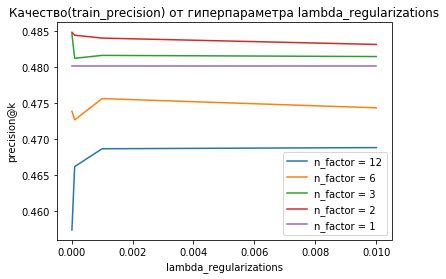

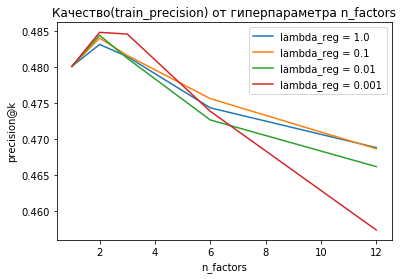

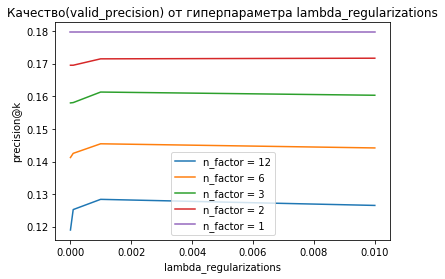

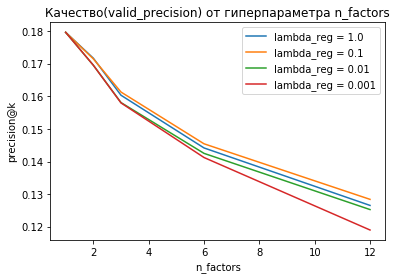

In [51]:
show_precision_on_hyper_params(hyperparam_result_0)
show_precision_on_hyper_params(hyperparam_result_0, precision_on_data='valid_precision')

#### Обобщающее заключение для valid данных после рассмотрения дополнительных параметров:

    Качество ростет при уменьшениии параметра n_factors
    вне зависимости от параметра регуляризации

#### Обобщающее заключение для train данных:

    Качество ростет при увеличении параметра n_factors (переобучение),
    имеется провал при n_factors=12 
    параметр регуляризации не влияет на качество

In [55]:
hyperparam_result.sort_values('fit_time', ascending=False)

,lambda_regularizations,n_factors,fit_time,train_precision,valid_precision
10,0.00010,200,6.134857,0.772389,0.105387
5,0.00100,200,6.066531,0.766467,0.108031
0,0.01000,200,6.059940,0.754702,0.108423
15,0.00001,200,5.871110,0.768707,0.104897
2,0.01000,50,3.523757,0.517407,0.105485
3,0.01000,25,3.444627,0.484914,0.109892
12,0.00010,50,3.414486,0.517407,0.100979
17,0.00001,50,3.408186,0.512925,0.099314
1,0.01000,100,3.402284,0.595198,0.103330
7,0.00100,50,3.362695,0.508443,0.100196


По времени зависимость видна из таблицы основной вклад вносит параметр n_factors, что кажеться естественным

In [56]:
hyperparam_result_0.sort_values('fit_time', ascending=False)

,lambda_regularizations,n_factors,fit_time,train_precision,valid_precision
1,1.000,6,2.690371,0.474350,0.144172
0,1.000,12,2.673662,0.468828,0.126543
16,0.001,6,2.231370,0.473870,0.141234
6,0.100,6,2.214629,0.475630,0.145446
11,0.010,6,2.203306,0.472669,0.142507
8,0.100,2,2.114206,0.484034,0.171499
12,0.010,3,2.111112,0.481232,0.158080
13,0.010,2,2.108017,0.484434,0.169540
17,0.001,3,2.098953,0.484594,0.157982
2,1.000,3,2.091671,0.481473,0.160333


при малых значениях n_factors зависимость слабо прослеживается

In [60]:
n_factors_1 =  [200, 300, 400, 500, 600]
lambda_regs_1 = [0.01]
hyperparam_result_1={
    'lambda_regularizations':[],
    'n_factors':[],
    'fit_time':[],
    'train_precision':[],
    'valid_precision':[]
}


first_time = time()
i=0
for lambda_reg in lambda_regs_1:
    for n_factor in n_factors_1:
        hyperparam_result_1['lambda_regularizations'].append(lambda_reg)
        hyperparam_result_1['n_factors'].append(n_factor)

        start_time = time()
        
        model = AlternatingLeastSquares(factors=n_factor, #k
                                regularization=lambda_reg,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)        
        model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=False)
        
        end_time = time()
        
        hyperparam_result_1['fit_time'].append(end_time-start_time)
        res_name = f'ALS: lambda_regularizations {lambda_reg}, n_factors: {n_factor}'
        
        train_result[res_name] = train_result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        train_precision = train_result.apply(lambda row: precision_at_k(row[res_name], row['actual']), axis=1).mean()
                
        hyperparam_result_1['train_precision'].append(train_precision)

        valid_result[res_name] = valid_result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        valid_precision = valid_result.apply(lambda row: precision_at_k(row[res_name], row['actual']), axis=1).mean()
        
        hyperparam_result_1['valid_precision'].append(valid_precision)
        
        cycle_time = time()
        i+=1
        print(f'Цикл {i} , времени прошло {(cycle_time-first_time):.2f}')



Цикл 1 , времени прошло 116.62
Цикл 2 , времени прошло 307.35
Цикл 3 , времени прошло 594.14
Цикл 4 , времени прошло 1026.94
Цикл 5 , времени прошло 1835.74


In [61]:
hyperparam_result_1_ = hyperparam_result_1
hyperparam_result_1 = pd.DataFrame(hyperparam_result_1)

In [64]:
hyperparam_result_1.sort_values('fit_time', ascending=False)

,lambda_regularizations,n_factors,fit_time,train_precision,valid_precision
4,0.01,600,23.182546,0.911885,0.092262
3,0.01,500,18.068928,0.903721,0.096082
2,0.01,400,12.262678,0.890116,0.098237
1,0.01,300,11.133487,0.849940,0.104407
0,0.01,200,7.501792,0.753341,0.110578


После дополнителных параетров видно при увеличении n_factors:
    
    fit_time растет,
    train_precision растет,
    а valid_precision падает 

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!

Получается для лучшего качетва параметр n_factors должен быть не больше 100, что сократит и время вычислений,
трудности ждать завершения вычислений и следить за температурой процессора на ноутбуке.

Хотелось бы посмотреть на оптимальный вариант для таких иследовательских вычисления на локальных пк.
P.S. (...applay(lambda...) говорили что не оптимально но наглядно, хотелось бы посмотреть как выглядит оптималььный вариант и если такой есть (и наглядный и быстрый))
